# Navigation

---


### <p style="text-align: center;">Miguel Carreira Neves</p>
<p style="text-align: center;">22/03/2022</p>

---

This notebook is a proposed solution using Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

For a detailed description of **how to run** this project and all dependencies needed check the `README.md`.

For more information and **implementation details** check the `Report.md`. It contains information about the network description, the agent details, interpretation of obtained results and possible future work ideas .

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed all necessary dependencies.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys
print (sys.version) # Python Version

3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


In [2]:
env = UnityEnvironment(file_name="Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Deep Q Learning NetworK

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


### Hyperparameters

Below are some of the hyperparameters used.

In [6]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

### Agent

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        originalTrain = False
        if self.qnetwork_local.training is True:
            originalTrain = True
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        if originalTrain is True:
            self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Deep Q Learning

In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, score_obj=13):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        score_obj (int): score objective to stop at when average is reached and save model
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=score_obj:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

### Train the Agent

Select whether to train it from the ground up or continue training from a model in memory.

If the model achieves the desired goal it will save itself onto a file and the training will finish.

In [17]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
agent.qnetwork_local.train()
fromMemory = input("Do you want to train using a network from memory? 0-Yes 1-No ")
score_objective = int(input("What is the score average over 100 episodes that you want to achieve?\n(Recommended a score of 13 when training a new network)\n"))
if fromMemory == "0":
    print("Continuing from Memory...")
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth',map_location=torch.device('cpu')))
    agent.qnetwork_target.load_state_dict(torch.load('checkpoint.pth',map_location=torch.device('cpu')))
    scores = dqn(eps_start=0.02, score_obj=score_objective)
else:
    print("Training from the ground up...")
    scores = dqn(score_obj=score_objective)

Do you want to train from memory? 0-Yes 1-No 1
Episode 100	Average Score: 0.42
Episode 200	Average Score: 3.67
Episode 300	Average Score: 6.36
Episode 400	Average Score: 10.86
Episode 500	Average Score: 12.83
Episode 600	Average Score: 14.22
Episode 700	Average Score: 15.32
Episode 800	Average Score: 15.37
Episode 900	Average Score: 15.43
Episode 1000	Average Score: 15.52
Episode 1046	Average Score: 16.00
Environment solved in 946 episodes!	Average Score: 16.00


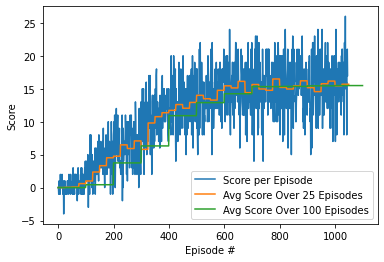

In [45]:
import matplotlib.pyplot as plt

# get scores averages over x episodes
averages_num = []
averages_100 = []
score_sum = 0
score_sum_100 = 0
i = 1
x_episodes = 25
for score in scores:
    score_sum+=score
    score_sum_100+=score
    if i%x_episodes == 0:
        score_sum = score_sum/x_episodes
        for j in range(0,x_episodes):
            averages_num.append(score_sum)
        if i%100 == 0:
            score_sum_100 = score_sum_100/100
            for j in range(0,100):
                averages_100.append(score_sum_100)
            score_sum_100 = 0
        score_sum=0
    i+=1

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score per Episode')
plt.plot(np.arange(len(averages_num)), averages_num, label='Avg Score Over ' +str(x_episodes)+ ' Episodes')
plt.plot(np.arange(len(averages_100)), averages_100, label='Avg Score Over 100 Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

### Watch the Agent

See how the Agent behaves in the enviroment after being trained. Choose if you want the model to be loaded from a file or to use the one just trained.

In [9]:
# load the weights from file
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
fromMemory = input("Do you want to test using network from memory? 0-Yes 1-No ")
if fromMemory == "0":
    print("Continuing from Memory...")
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth',map_location=torch.device('cpu')))
else:
    print("Using the current trained network. If no one has previously been trained agent will act randomly.")
agent.qnetwork_local.eval()
max_t = 1000
scores_test = []

test_episodes = 100
for episode in range(test_episodes):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]   # get the next state
    score = 0
    for t in range(max_t):
        
        action = agent.act(state)
        env_info = env.step(action)[brain_name]

        state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]
        score += reward
        if done:
            break 
    scores_test.append(score)
    print("Episode: " + str(episode+1) + " Score: " + str(score))
            

Do you want to test using network from memory? 0-Yes 1-No 0
Continuing from Memory...
Episode: 1 Score: 7.0
Episode: 2 Score: 17.0
Episode: 3 Score: 13.0
Episode: 4 Score: 18.0
Episode: 5 Score: 17.0
Episode: 6 Score: 17.0
Episode: 7 Score: 8.0
Episode: 8 Score: 16.0
Episode: 9 Score: 16.0
Episode: 10 Score: 16.0
Episode: 11 Score: 13.0
Episode: 12 Score: 18.0
Episode: 13 Score: 20.0
Episode: 14 Score: 10.0
Episode: 15 Score: 16.0
Episode: 16 Score: 14.0
Episode: 17 Score: 11.0
Episode: 18 Score: 13.0
Episode: 19 Score: 19.0
Episode: 20 Score: 10.0


KeyboardInterrupt: 

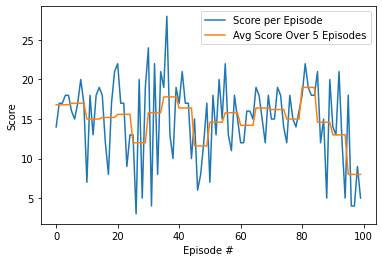

In [20]:
import matplotlib.pyplot as plt

# get scores averages over x episodes
averages_test = []
score_sum_test = 0
i = 1
test_episodes_avg = 5
for score in scores_test:
    score_sum_test+=score
    if i%test_episodes_avg == 0:
        score_sum_test = score_sum_test/test_episodes_avg
        for j in range(0,test_episodes_avg):
            averages_test.append(score_sum_test)
        score_sum_test=0
    i+=1

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_test)), scores_test, label='Score per Episode')
plt.plot(np.arange(len(averages_test)), averages_test, label='Avg Score Over ' +str(test_episodes_avg)+ ' Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [ ]:
env.close()

### Congrats you finished experimenting with this Project

Read the Report.md for information on Future Work and implementation details